## Khai phá bộ dữ liệu

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here


In [ ]:
# Đọc dữ liệu
file_path = "All.csv"
data = pd.read_csv(file_path)

In [ ]:
# Thông tin dữ liệu
print("Thông tin dữ liệu:")
print(data.info())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36707 entries, 0 to 36706
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      36707 non-null  int64  
 1   domain_token_count               36707 non-null  int64  
 2   path_token_count                 36707 non-null  int64  
 3   avgdomaintokenlen                36707 non-null  float64
 4   longdomaintokenlen               36707 non-null  int64  
 5   avgpathtokenlen                  36427 non-null  float64
 6   tld                              36707 non-null  int64  
 7   charcompvowels                   36707 non-null  int64  
 8   charcompace                      36707 non-null  int64  
 9   ldl_url                          36707 non-null  int64  
 10  ldl_domain                       36707 non-null  int64  
 11  ldl_path                         36707 non-null  int64  
 12 

In [ ]:
# Phân phối nhãn trong tập dữ liệu
print("\nPhân phối nhãn:")
print(data['URL_Type_obf_Type'].value_counts())


Phân phối nhãn:
URL_Type_obf_Type
Defacement    7930
benign        7781
phishing      7586
malware       6712
spam          6698
Name: count, dtype: int64


## Tiền xử lý dữ liệu

### Kiểm tra và xử lý giá trị thiếu (Missing Values)


Kiểm tra giá trị không hợp lệ (NaN, Infinity) trong dữ liệu:
- Xác định cột nào chứa các giá trị bất thường.
- Loại bỏ hoặc thay thế những giá trị này.

In [ ]:
# Tìm các giá trị NaN
print("Số lượng giá trị NaN trong mỗi cột:")
print(data.isnull().sum())

numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
# Exclude 'URL_Type_obf_Type' if it's in numerical_columns
if 'URL_Type_obf_Type' in numerical_columns:
    numerical_columns = numerical_columns.drop('URL_Type_obf_Type')

# Tìm giá trị Infinity
print("\nCác cột chứa giá trị Infinity:")
print(data[numerical_columns].applymap(np.isinf).sum())


Số lượng giá trị NaN trong mỗi cột:
Querylength                 0
domain_token_count          0
path_token_count            0
avgdomaintokenlen           0
longdomaintokenlen          0
                         ... 
Entropy_DirectoryName    8468
Entropy_Filename          236
Entropy_Extension          40
Entropy_Afterpath           6
URL_Type_obf_Type           0
Length: 80, dtype: int64

Các cột chứa giá trị Infinity:


<ipython-input-8-047bba097c55>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(data[numerical_columns].applymap(np.isinf).sum())


Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
longdomaintokenlen       0
                        ..
Entropy_Domain           0
Entropy_DirectoryName    0
Entropy_Filename         0
Entropy_Extension        0
Entropy_Afterpath        0
Length: 79, dtype: int64


Xử lý giá trị không hợp lệ:
- Thay thế Infinity: Có thể thay thế bằng giá trị lớn nhất hợp lệ trong cột hoặc một ngưỡng hợp lý.
- Thay thế NaN: Có thể thay bằng giá trị trung bình (mean), trung vị (median), hoặc loại bỏ hàng chứa giá trị NaN.

In [ ]:
# Thay thế Infinity bằng giá trị lớn nhất hợp lệ trong cột
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Điền giá trị NaN bằng giá trị trung bình
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

In [ ]:
# Kiểm tra lại NaN và Infinity
print("Giá trị NaN sau khi xử lý:", data.isnull().sum().sum())
print("Giá trị Infinity sau khi xử lý:", data[numerical_columns].applymap(np.isinf).sum().sum())


Giá trị NaN sau khi xử lý: 0


<ipython-input-10-c05e7d350fde>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print("Giá trị Infinity sau khi xử lý:", data[numerical_columns].applymap(np.isinf).sum().sum())


Giá trị Infinity sau khi xử lý: 0


### Xử lý cột đích (URL_Type_obf_Type)
Cột URL_Type_obf_Type là biến phân loại (object), cần mã hóa để mô hình sử dụng được.

In [ ]:
# Mã hóa nhãn
label_encoder = LabelEncoder()
data['URL_Type_obf_Type'] = label_encoder.fit_transform(data['URL_Type_obf_Type'])

In [ ]:
print(label_encoder.classes_)

['Defacement' 'benign' 'malware' 'phishing' 'spam']


In [ ]:
# In 10 mẫu ngẫu nhiên của cột URL_Type_obf_Type
print(data['URL_Type_obf_Type'].sample(10))


26526    3
19922    2
22405    2
21705    2
27090    3
27139    3
17113    2
4445     0
9987     1
30210    4
Name: URL_Type_obf_Type, dtype: int64


### Chuẩn hóa dữ liệu (Normalization/Scaling)
- Các đặc trưng liên tục (ví dụ: urlLen, domainlength, pathLength, Entropy_URL, ...) có giá trị khác nhau về phạm vi.
- Sử dụng MinMaxScaler hoặc StandardScaler để đưa tất cả đặc trưng về cùng một thang đo.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


In [ ]:
print(data.head(5))

   Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
0          0.0            0.117647          0.073529           0.142857   
1          0.0            0.117647          0.073529           0.142857   
2          0.0            0.117647          0.073529           0.142857   
3          0.0            0.117647          0.176471           0.142857   
4          0.0            0.117647          0.088235           0.142857   

   longdomaintokenlen  avgpathtokenlen       tld  charcompvowels  charcompace  \
0            0.196721         0.041905  0.117647        0.041451     0.021127   
1            0.196721         0.057143  0.117647        0.062176     0.028169   
2            0.196721         0.055238  0.117647        0.062176     0.035211   
3            0.196721         0.052381  0.117647        0.165803     0.112676   
4            0.196721         0.069841  0.117647        0.093264     0.077465   

   ldl_url  ...  SymbolCount_FileName  SymbolCount_Extension  

### Xử lý dữ liệu mất cân bằng (Imbalanced Data)
Nếu dữ liệu phân phối không đồng đều giữa các nhãn, cần xử lý để tránh ảnh hưởng đến mô hình:
- Undersampling: Giảm số lượng mẫu của lớp chiếm đa số.
- Oversampling: Tăng số lượng mẫu của lớp chiếm thiểu số (ví dụ: SMOTE).

In [ ]:
from imblearn.over_sampling import SMOTE

# Áp dụng SMOTE để xử lý mất cân bằng
X = data.drop(columns=['URL_Type_obf_Type'])
y = data['URL_Type_obf_Type']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Kích thước dữ liệu sau khi xử lý mất cân bằng:", X_resampled.shape)


Kích thước dữ liệu sau khi xử lý mất cân bằng: (39650, 79)


In [ ]:
# Lưu dữ liệu đã tiền xử lý vào file CSV
data.to_csv("dataset.csv", index=False)

## Trực quan hoá dữ liệu

### Phân phối của các nhãn (label)
Hiển thị phân phối của cột URL_Type_obf_Type để xem dữ liệu có bị mất cân bằng không.

<ipython-input-18-fb1fee8c50a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="URL_Type_obf_Type", palette="viridis", order=data["URL_Type_obf_Type"].value_counts().index)


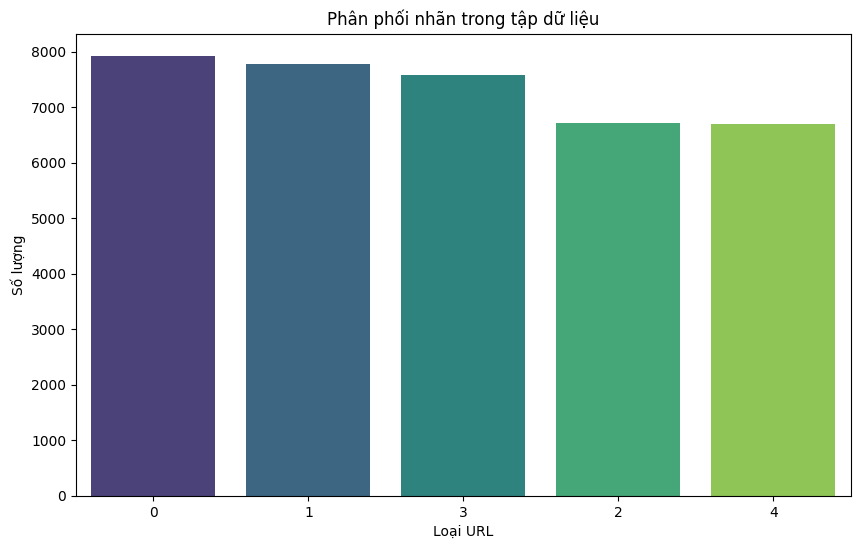

In [ ]:
# Vẽ biểu đồ phân phối nhãn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="URL_Type_obf_Type", palette="viridis", order=data["URL_Type_obf_Type"].value_counts().index)
plt.title("Phân phối nhãn trong tập dữ liệu")
plt.xlabel("Loại URL")
plt.ylabel("Số lượng")
plt.show()

### Phân phối của các đặc trưng liên tục
Chọn một vài đặc trưng quan trọng (hoặc tất cả đặc trưng số) để trực quan hóa phân phối.

In [ ]:
# Loại bỏ khoảng trắng thừa trong tên cột
data.columns = data.columns.str.strip()

# Kiểm tra lại tên cột
print(data.columns)

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

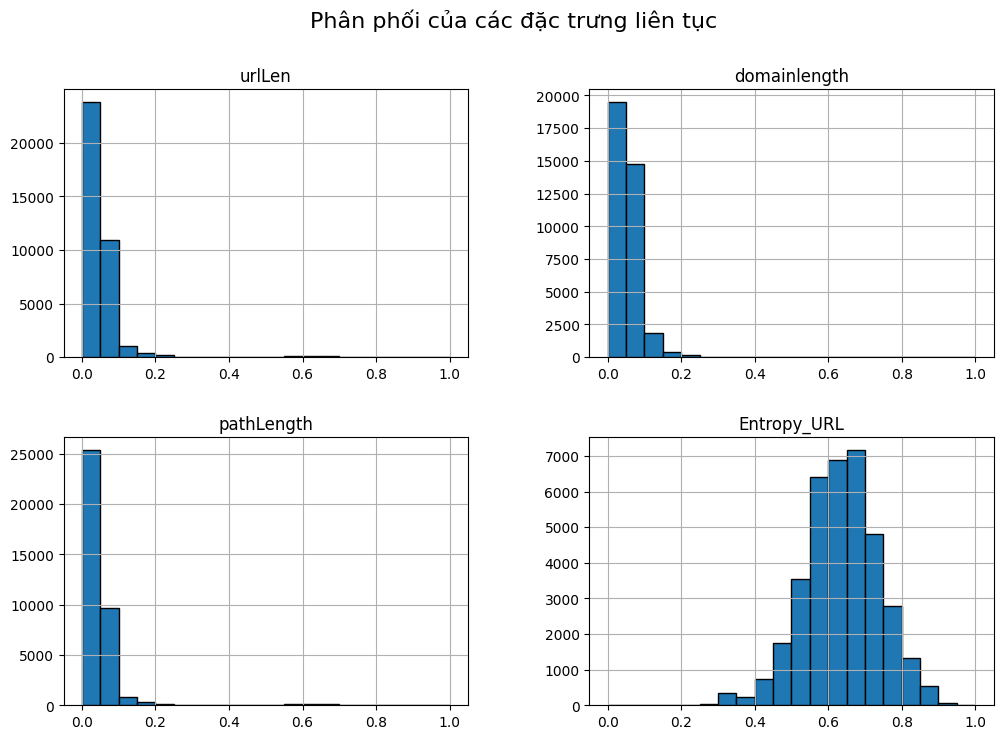

In [ ]:
# Histogram cho một số cột quan trọng
important_features = ['urlLen', 'domainlength', 'pathLength', 'Entropy_URL']
data[important_features].hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle('Phân phối của các đặc trưng liên tục', fontsize=16)
plt.show()

### Mối quan hệ giữa các đặc trưng
Sử dụng ma trận tương quan để trực quan hóa mối quan hệ giữa các đặc trưng.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính toán ma trận tương quan
corr_matrix = data.corr()

# Vẽ heatmap với các trọng số (hệ số tương quan) hiển thị
plt.figure(figsize=(42, 32 ))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các đặc trưng', fontsize=16)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Lọc các giá trị tương quan lớn hơn 0.8

In [ ]:
high_corr = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1.0)].stack().reset_index()
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
print(high_corr)

                 Feature 1                 Feature 2  Correlation
0              Querylength               charcompace     0.844110
1              Querylength                   ldl_url     0.953382
2              Querylength                  ldl_path     0.954891
3              Querylength                ldl_getArg     0.975698
4              Querylength                    urlLen     0.957545
..                     ...                       ...          ...
413  Entropy_DirectoryName          Entropy_Filename     0.947075
414       Entropy_Filename  NumberRate_DirectoryName     0.807683
415       Entropy_Filename      NumberRate_Extension     0.815707
416       Entropy_Filename     Entropy_DirectoryName     0.947075
417      Entropy_Afterpath      NumberRate_AfterPath     0.982538

[418 rows x 3 columns]


### Boxplot để kiểm tra ngoại lệ
Hiển thị các ngoại lệ trong các đặc trưng liên tục quan trọng.

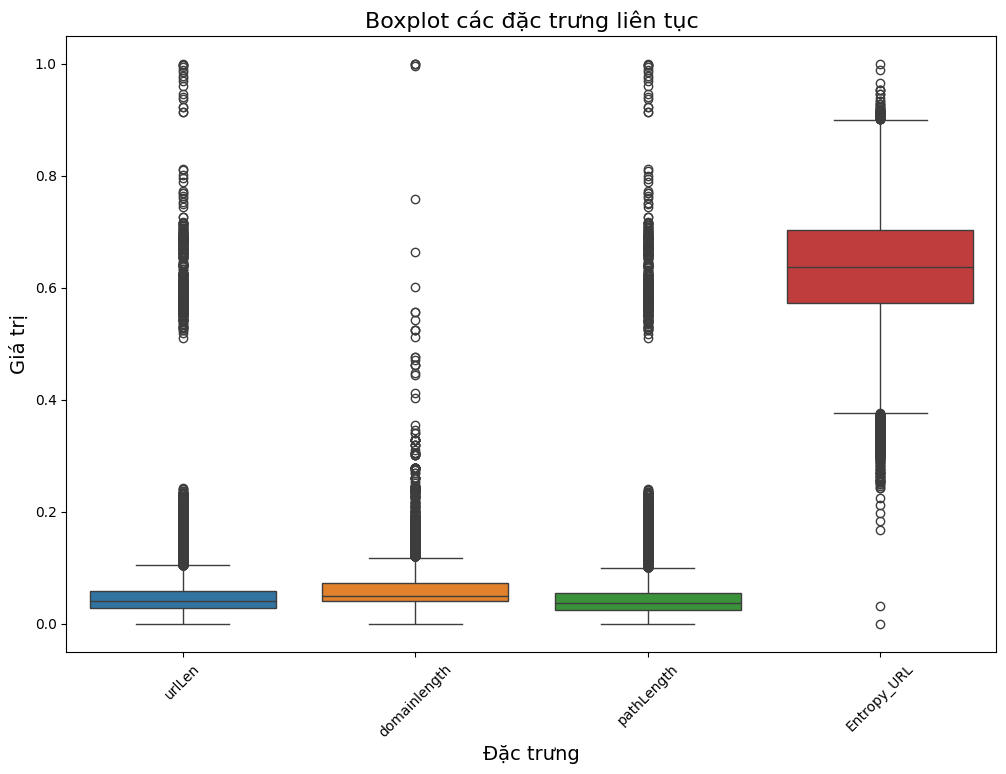

In [ ]:
# Boxplot cho một số đặc trưng
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[important_features])
plt.title('Boxplot các đặc trưng liên tục', fontsize=16)
plt.xlabel('Đặc trưng', fontsize=14)
plt.ylabel('Giá trị', fontsize=14)
plt.xticks(rotation=45)
plt.show()


### Phân phối URL theo độ dài (urlLen)
Phân tích mối quan hệ giữa độ dài URL (urlLen) và loại URL (URL_Type_obf_Type).


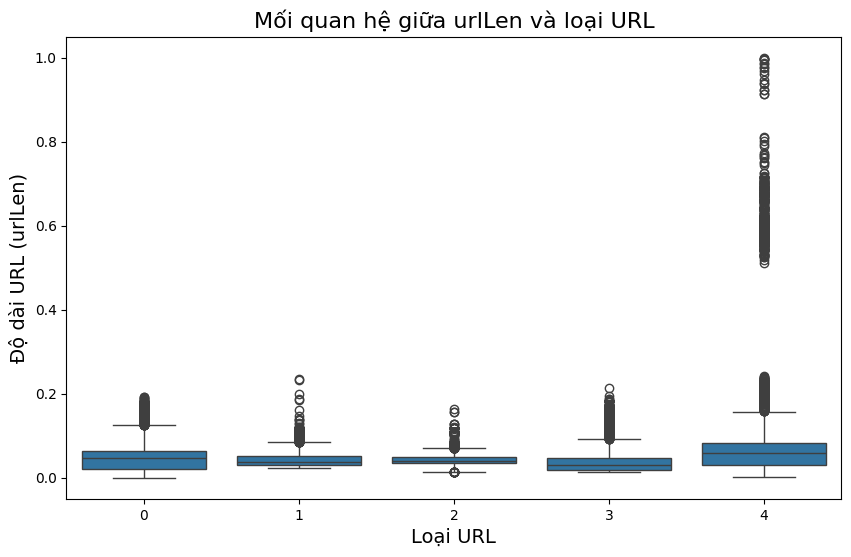

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='URL_Type_obf_Type', y='urlLen', data=data)
plt.title('Mối quan hệ giữa urlLen và loại URL', fontsize=16)
plt.xlabel('Loại URL', fontsize=14)
plt.ylabel('Độ dài URL (urlLen)', fontsize=14)
plt.show()


### Phân phối các giá trị số bằng KDE (Kernel Density Estimate)
Hiển thị phân phối của các cột Entropy_URL, pathLength, v.v. bằng KDE để quan sát dạng dữ liệu.

<ipython-input-25-8025f36e9783>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Entropy_URL'], label='Entropy_URL', shade=True, color='blue')
<ipython-input-25-8025f36e9783>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['pathLength'], label='pathLength', shade=True, color='green')


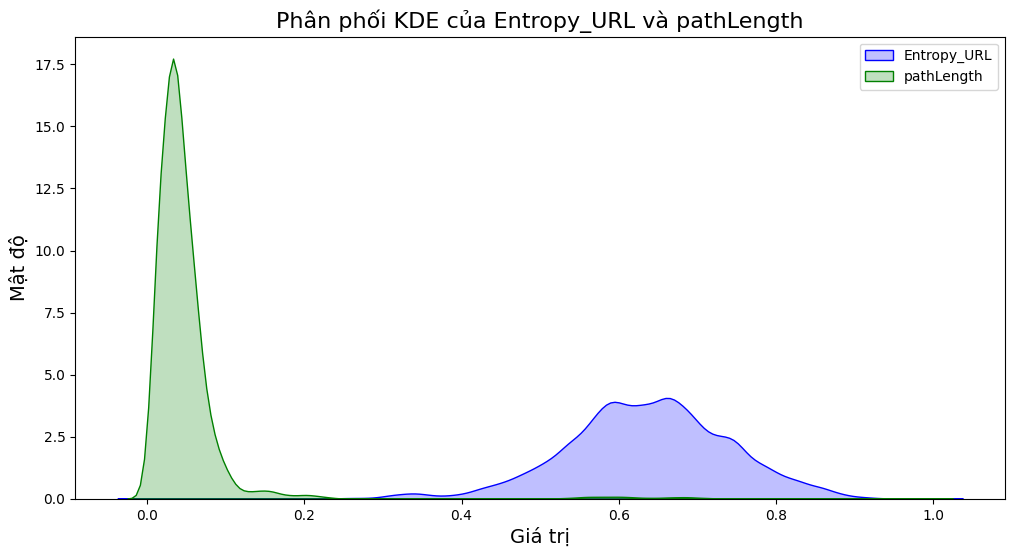

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data['Entropy_URL'], label='Entropy_URL', shade=True, color='blue')
sns.kdeplot(data['pathLength'], label='pathLength', shade=True, color='green')
plt.title('Phân phối KDE của Entropy_URL và pathLength', fontsize=16)
plt.xlabel('Giá trị', fontsize=14)
plt.ylabel('Mật độ', fontsize=14)
plt.legend()
plt.show()


### Cặp mối quan hệ (Pairplot)
Trực quan hóa mối quan hệ giữa nhiều đặc trưng quan trọng với nhãn.

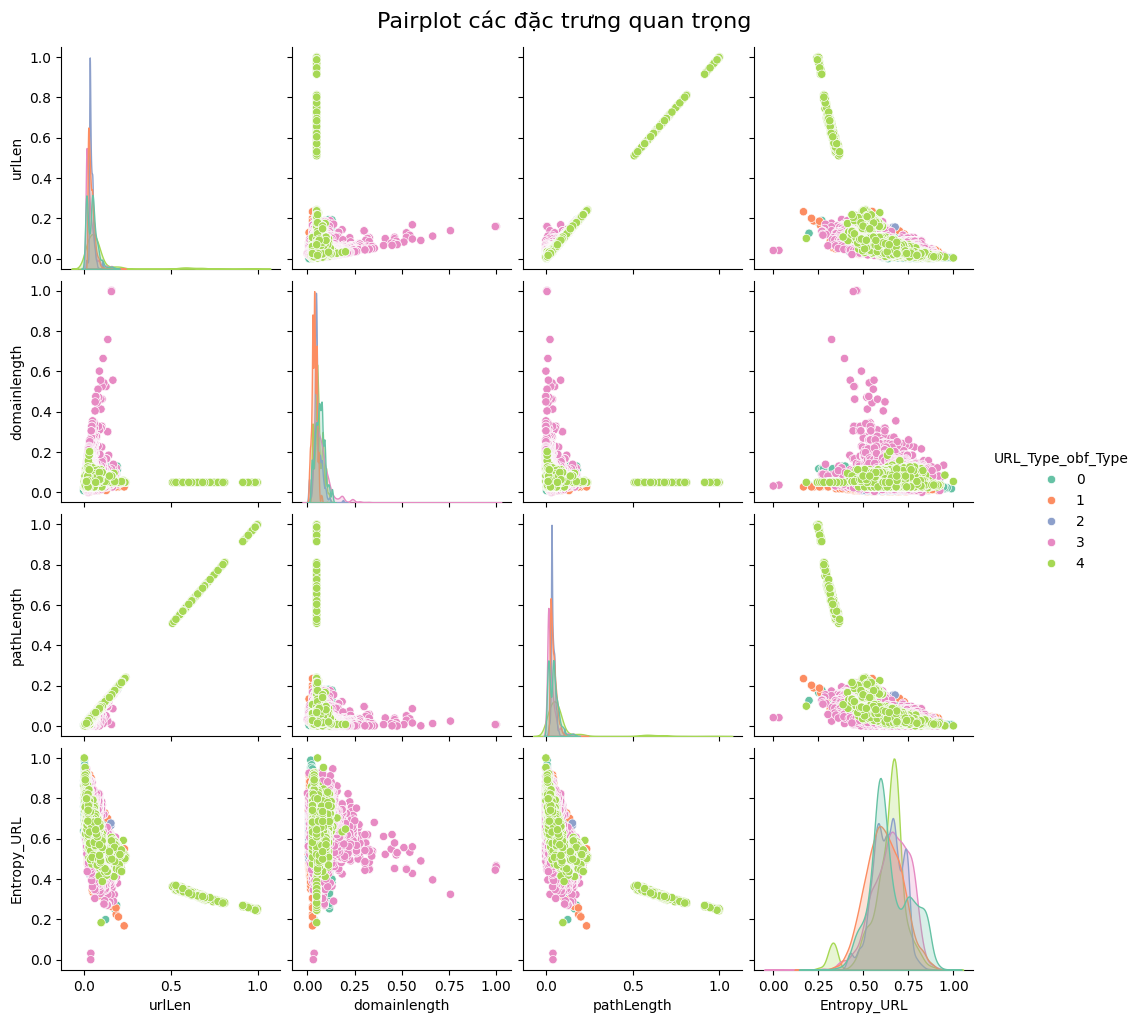

In [ ]:
from seaborn import pairplot

# Chỉ chọn một số đặc trưng và nhãn để trực quan hóa
selected_features = ['urlLen', 'domainlength', 'pathLength', 'Entropy_URL', 'URL_Type_obf_Type']
sns.pairplot(data[selected_features], hue='URL_Type_obf_Type', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot các đặc trưng quan trọng', fontsize=16, y=1.02)
plt.show()


## Lựa chọn đặc trưng

Chọn ra 20 đặc trưng quan trọng nhất cho bài toán nhận diện URL độc hại bằng cách kết hợp các phương pháp, sử dụng sự pha trộn giữa các cách tiếp cận khác nhau để đảm bảo độ chính xác và tính toàn diện.

### Phương pháp 1: Random Forest (Tree-based Feature Importance)
1. Lý do chọn:
- Random Forest cung cấp thông tin quan trọng của đặc trưng dựa trên độ giảm impurity (Gini hoặc entropy) qua tất cả các cây trong mô hình.
- Phù hợp với cả dữ liệu phi tuyến và có thể xử lý mối quan hệ phức tạp giữa các đặc trưng.
2. Kết quả: Danh sách các đặc trưng có tầm quan trọng cao.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature names from X.columns if X is a pandas DataFrame
feature_names = X.columns if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])]

feature_importances_rf = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_rf_features = feature_importances_rf.head(20)


In [ ]:
print("\nTop 20 đặc trưng quan trọng nhất với Random Forest:")
print(top_rf_features)


Top 20 đặc trưng quan trọng nhất với Random Forest:
                      Feature  Importance
34          NumberofDotsinURL    0.029454
68         SymbolCount_Domain    0.027843
27                ArgUrlRatio    0.027186
3           avgdomaintokenlen    0.026481
45          host_letter_count    0.026030
1          domain_token_count    0.024838
20               domainlength    0.024778
19                     urlLen    0.023918
74             Entropy_Domain    0.023412
28              argDomanRatio    0.022138
6                         tld    0.022028
36    CharacterContinuityRate    0.021906
46      Directory_LetterCount    0.021400
26               pathurlRatio    0.021133
51   Domain_LongestWordLength    0.019514
61             NumberRate_URL    0.019126
69  SymbolCount_Directoryname    0.018896
22                  subDirLen    0.018798
29             domainUrlRatio    0.017772
48      Extension_LetterCount    0.017471


<ipython-input-29-3faccea5bd80>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rf_features, x="Importance", y="Feature", palette="viridis")


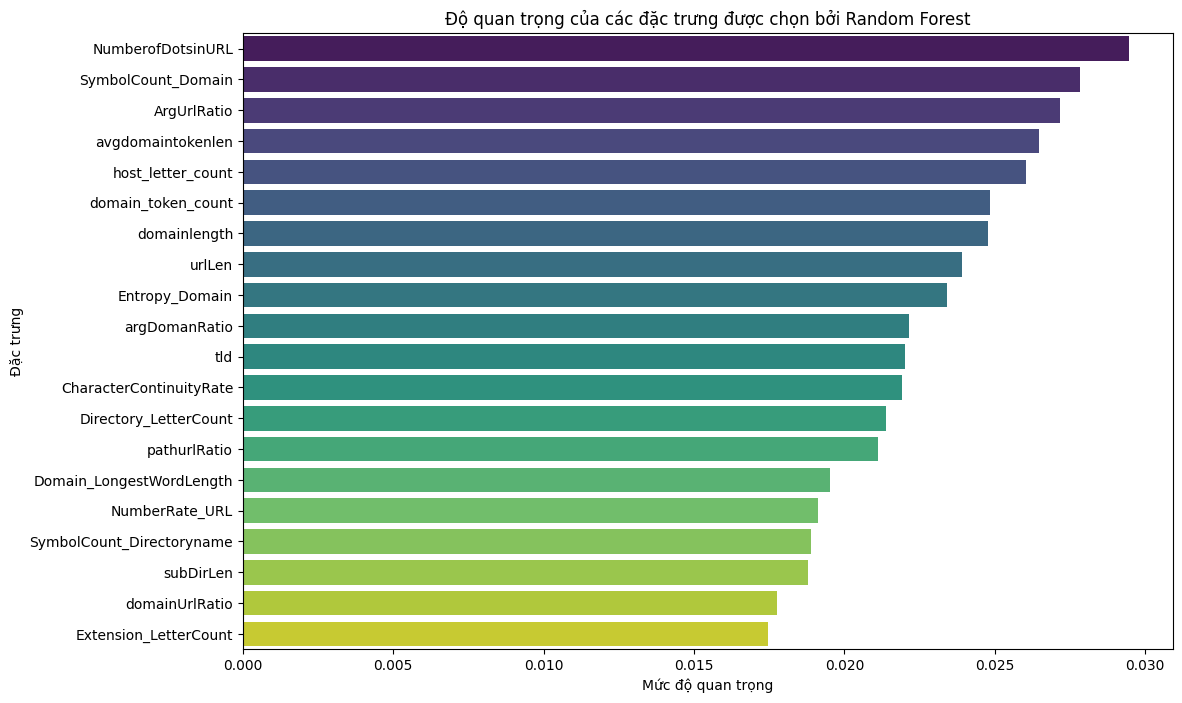

In [ ]:
# Vẽ biểu đồ các đặc trưng quan trọng nhất
plt.figure(figsize=(12, 8))
sns.barplot(data=top_rf_features, x="Importance", y="Feature", palette="viridis")
plt.title("Độ quan trọng của các đặc trưng được chọn bởi Random Forest")
plt.xlabel("Mức độ quan trọng")
plt.ylabel("Đặc trưng")
plt.show()

In [ ]:
top_rf_features = feature_importances_rf.head(20)['Feature'].tolist()
print(top_rf_features)

['NumberofDotsinURL', 'SymbolCount_Domain', 'ArgUrlRatio', 'avgdomaintokenlen', 'host_letter_count', 'domain_token_count', 'domainlength', 'urlLen', 'Entropy_Domain', 'argDomanRatio', 'tld', 'CharacterContinuityRate', 'Directory_LetterCount', 'pathurlRatio', 'Domain_LongestWordLength', 'NumberRate_URL', 'SymbolCount_Directoryname', 'subDirLen', 'domainUrlRatio', 'Extension_LetterCount']


In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_rf = pd.concat([data[top_rf_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_rf.to_csv("dataset_rf.csv", index=False)

In [ ]:
# Lấy 60 đặc trưng còn lại
# Lấy danh sách tất cả các đặc trưng
all_features = set(feature_names)

# Lấy danh sách 20 đặc trưng quan trọng nhất
rf_20_features = set(top_rf_features)

# Lấy danh sách 60 đặc trưng còn lại
rf_60_features = list(all_features - rf_20_features)

print(rf_60_features)

['this.fileExtLen', 'spcharUrl', 'pathLength', 'Filename_LetterCount', 'Query_DigitCount', 'dld_getArg', 'delimeter_Domain', 'executable', 'Path_LongestWordLength', 'LongestPathTokenLength', 'argPathRatio', 'SymbolCount_Afterpath', 'ldl_domain', 'ISIpAddressInDomainName', 'ldl_url', 'path_token_count', 'Entropy_DirectoryName', 'ArgLen', 'ldl_path', 'ldl_getArg', 'delimeter_Count', 'NumberRate_DirectoryName', 'delimeter_path', 'Querylength', 'Extension_DigitCount', 'avgpathtokenlen', 'LongestVariableValue', 'SymbolCount_FileName', 'dld_path', 'Entropy_Extension', 'charcompace', 'URL_DigitCount', 'pathDomainRatio', 'NumberRate_FileName', 'dld_domain', 'dld_filename', 'host_DigitCount', 'Entropy_Afterpath', 'SymbolCount_URL', 'ldl_filename', 'dld_url', 'URL_Letter_Count', 'charcompvowels', 'sub-Directory_LongestWordLength', 'NumberRate_AfterPath', 'isPortEighty', 'URLQueries_variable', 'NumberRate_Extension', 'Entropy_URL', 'File_name_DigitCount', 'Query_LetterCount', 'NumberRate_Domain',

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_rf_60 = pd.concat([data[rf_60_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_rf_60.to_csv("dataset_rf_60.csv", index=False)

### Phương pháp 2: Mutual Information
1. Lý do chọn:
- Mutual Information đo lường sự phụ thuộc (phi tuyến) giữa các đặc trưng và nhãn đầu ra.
- Có thể phát hiện các đặc trưng quan trọng mà các phương pháp dựa trên impurity (như Random Forest) bỏ qua.
2. Kết quả: Danh sách các đặc trưng có độ phụ thuộc mạnh với nhãn.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)
feature_importances_mi = pd.DataFrame({
    "Feature": feature_names,
    "Mutual Info": mutual_info
}).sort_values(by="Mutual Info", ascending=False)

top_mi_features = feature_importances_mi.head(20)


In [ ]:
print("\nTop 20 đặc trưng quan trọng nhất với Mutual Information:")
print(top_mi_features)


Top 20 đặc trưng quan trọng nhất với Mutual Information:
                    Feature  Mutual Info
74           Entropy_Domain     1.075707
26             pathurlRatio     0.763635
27              ArgUrlRatio     0.753227
31             argPathRatio     0.752552
28            argDomanRatio     0.722871
30          pathDomainRatio     0.715467
29           domainUrlRatio     0.712690
61           NumberRate_URL     0.697995
36  CharacterContinuityRate     0.653776
75    Entropy_DirectoryName     0.616021
64      NumberRate_FileName     0.601690
76         Entropy_Filename     0.580325
65     NumberRate_Extension     0.538123
5           avgpathtokenlen     0.524765
66     NumberRate_AfterPath     0.501647
77        Entropy_Extension     0.497470
73              Entropy_URL     0.497255
78        Entropy_Afterpath     0.478859
3         avgdomaintokenlen     0.450754
50   LongestPathTokenLength     0.405923


<ipython-input-36-378fe4dcc969>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mi_features, x="Mutual Info", y="Feature", palette="viridis")


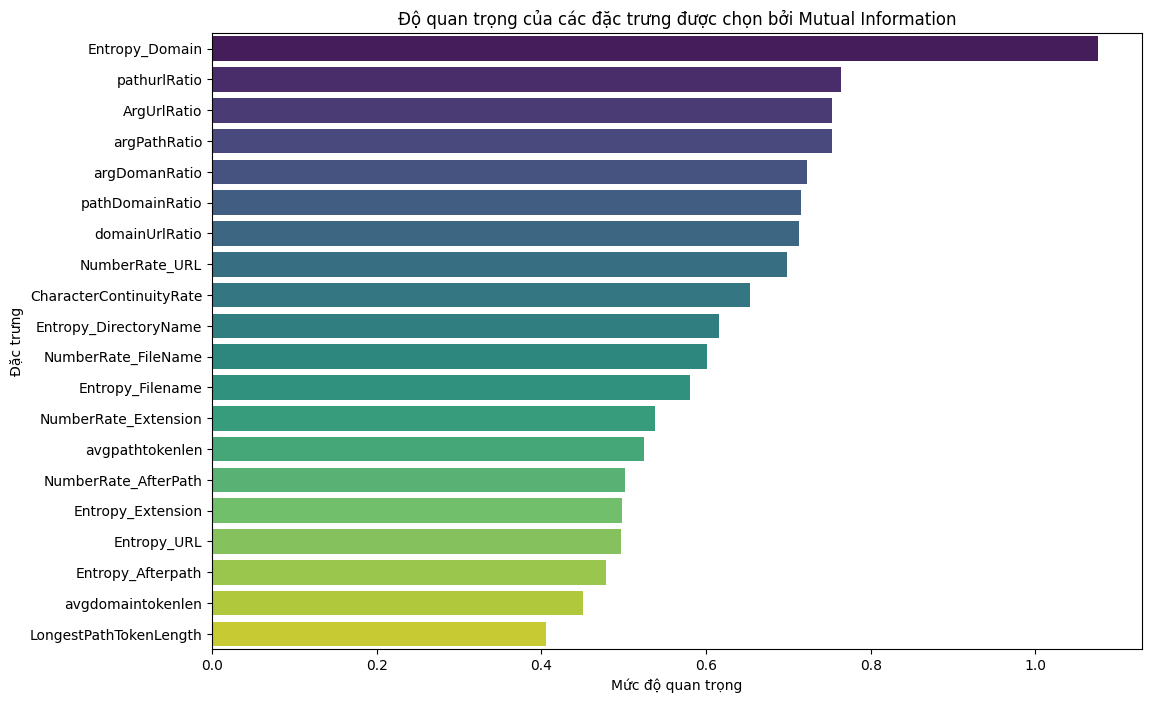

In [ ]:
# Vẽ biểu đồ các đặc trưng quan trọng nhất
plt.figure(figsize=(12, 8))
sns.barplot(data=top_mi_features, x="Mutual Info", y="Feature", palette="viridis")
plt.title("Độ quan trọng của các đặc trưng được chọn bởi Mutual Information")
plt.xlabel("Mức độ quan trọng")
plt.ylabel("Đặc trưng")
plt.show()

In [ ]:
top_mi_features = feature_importances_mi.head(20)['Feature'].tolist()
print(top_mi_features)

['Entropy_Domain', 'pathurlRatio', 'ArgUrlRatio', 'argPathRatio', 'argDomanRatio', 'pathDomainRatio', 'domainUrlRatio', 'NumberRate_URL', 'CharacterContinuityRate', 'Entropy_DirectoryName', 'NumberRate_FileName', 'Entropy_Filename', 'NumberRate_Extension', 'avgpathtokenlen', 'NumberRate_AfterPath', 'Entropy_Extension', 'Entropy_URL', 'Entropy_Afterpath', 'avgdomaintokenlen', 'LongestPathTokenLength']


In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_mi = pd.concat([data[top_mi_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_mi.to_csv("dataset_mi.csv", index=False)

In [ ]:
# Lấy 60 đặc trưng còn lại

# Lấy danh sách 20 đặc trưng quan trọng nhất
mi_20_features = set(top_mi_features)

# Lấy danh sách 60 đặc trưng còn lại
mi_60_features = list(all_features - mi_20_features)

print(mi_60_features)

['this.fileExtLen', 'spcharUrl', 'pathLength', 'Filename_LetterCount', 'Query_DigitCount', 'Extension_LetterCount', 'dld_getArg', 'executable', 'delimeter_Domain', 'Path_LongestWordLength', 'NumberofDotsinURL', 'SymbolCount_Afterpath', 'ldl_domain', 'SymbolCount_Directoryname', 'Domain_LongestWordLength', 'ISIpAddressInDomainName', 'ldl_url', 'domain_token_count', 'path_token_count', 'ArgLen', 'host_letter_count', 'ldl_path', 'ldl_getArg', 'delimeter_Count', 'NumberRate_DirectoryName', 'delimeter_path', 'Querylength', 'domainlength', 'Extension_DigitCount', 'LongestVariableValue', 'SymbolCount_FileName', 'dld_path', 'tld', 'charcompace', 'URL_DigitCount', 'dld_domain', 'dld_filename', 'host_DigitCount', 'urlLen', 'SymbolCount_URL', 'ldl_filename', 'dld_url', 'URL_Letter_Count', 'charcompvowels', 'sub-Directory_LongestWordLength', 'isPortEighty', 'SymbolCount_Domain', 'URLQueries_variable', 'File_name_DigitCount', 'Query_LetterCount', 'NumberRate_Domain', 'Arguments_LongestWordLength', 

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_mi_60 = pd.concat([data[mi_60_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_mi_60.to_csv("dataset_mi_60.csv", index=False)

### Phương pháp 3: Recursive Feature Elimination (RFE)
1. Lý do chọn:
- RFE giúp chọn các đặc trưng bằng cách lặp lại quá trình huấn luyện mô hình và loại bỏ những đặc trưng kém quan trọng nhất.
- Phương pháp này tối ưu hóa dựa trên một mô hình cụ thể (ví dụ: Random Forest hoặc Logistic Regression).
2. Kết quả: Danh sách các đặc trưng tốt nhất sau khi lược bỏ dần các đặc trưng kém quan trọng.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Khởi tạo mô hình RFE với RandomForestClassifier
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=20)

# Huấn luyện RFE
rfe.fit(X, y)

# Lấy danh sách các đặc trưng được chọn
top_rfe_features = [feature for feature, selected in zip(feature_names, rfe.support_) if selected]

# Hiển thị danh sách các đặc trưng được chọn
print("Top 20 đặc trưng được chọn bởi RFE:")
print(top_rfe_features)


Top 20 đặc trưng được chọn bởi RFE:
['domain_token_count', 'avgdomaintokenlen', 'avgpathtokenlen', 'urlLen', 'domainlength', 'pathurlRatio', 'ArgUrlRatio', 'argDomanRatio', 'argPathRatio', 'NumberofDotsinURL', 'CharacterContinuityRate', 'host_letter_count', 'Directory_LetterCount', 'Extension_LetterCount', 'LongestPathTokenLength', 'spcharUrl', 'NumberRate_URL', 'NumberRate_Extension', 'SymbolCount_Domain', 'Entropy_Domain']


<ipython-input-42-764d40b51ddb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rfe_importance_df, x="Importance", y="Feature", palette="viridis")


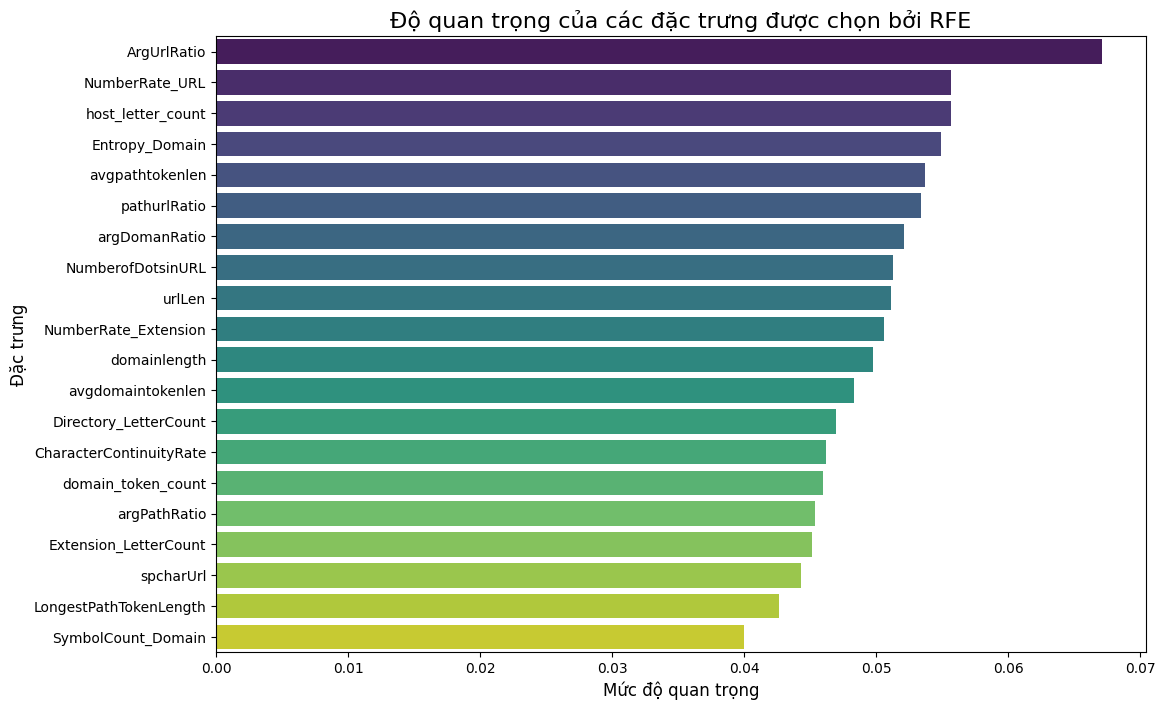

In [ ]:
# Chuyển đổi top_rfe_features thành DataFrame
top_rfe_importance_df = pd.DataFrame({
    "Feature": top_rfe_features,
    "Importance": rfe.estimator_.feature_importances_
})

# Sắp xếp theo mức độ quan trọng
top_rfe_importance_df = top_rfe_importance_df.sort_values(by="Importance", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(data=top_rfe_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Độ quan trọng của các đặc trưng được chọn bởi RFE", fontsize=16)
plt.xlabel("Mức độ quan trọng", fontsize=12)
plt.ylabel("Đặc trưng", fontsize=12)
plt.show()


In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_rfe = pd.concat([data[top_rfe_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_rfe.to_csv("dataset_rfe.csv", index=False)

In [ ]:
# Lấy 60 đặc trưng còn lại

# Lấy danh sách 20 đặc trưng quan trọng nhất
rfe_20_features = set(top_rfe_features)

# Lấy danh sách 60 đặc trưng còn lại
rfe_60_features = list(all_features - rfe_20_features)

print(rfe_60_features)

['this.fileExtLen', 'pathLength', 'Filename_LetterCount', 'Query_DigitCount', 'dld_getArg', 'delimeter_Domain', 'executable', 'Path_LongestWordLength', 'SymbolCount_Afterpath', 'ldl_domain', 'SymbolCount_Directoryname', 'Domain_LongestWordLength', 'ISIpAddressInDomainName', 'ldl_url', 'path_token_count', 'Entropy_DirectoryName', 'ArgLen', 'domainUrlRatio', 'ldl_path', 'ldl_getArg', 'delimeter_Count', 'NumberRate_DirectoryName', 'delimeter_path', 'Querylength', 'Extension_DigitCount', 'LongestVariableValue', 'SymbolCount_FileName', 'dld_path', 'tld', 'Entropy_Extension', 'charcompace', 'URL_DigitCount', 'pathDomainRatio', 'NumberRate_FileName', 'dld_domain', 'dld_filename', 'host_DigitCount', 'Entropy_Afterpath', 'SymbolCount_URL', 'ldl_filename', 'dld_url', 'URL_Letter_Count', 'charcompvowels', 'sub-Directory_LongestWordLength', 'NumberRate_AfterPath', 'isPortEighty', 'URLQueries_variable', 'Entropy_URL', 'File_name_DigitCount', 'Query_LetterCount', 'NumberRate_Domain', 'Arguments_Long

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_rfe_60 = pd.concat([data[rfe_60_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_rfe_60.to_csv("dataset_rfe_60.csv", index=False)

### Phương pháp 4: SelectKBest

In [ ]:
# Lựa chọn các đặc trưng tốt nhất bằng SelectKBest
k = 20  # Số lượng đặc trưng mong muốn
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
# Tên các đặc trưng được chọn
feature_names = data.select_dtypes(include=['int64', 'float64']).drop(columns=['URL_Type_obf_Type'], errors='ignore').columns

# Use feature_names and selector.get_support to get the selected features
top_skbest_features = feature_names[selector.get_support()]

print(f"\nTop 20 đặc trưng quan trọng nhất với SelectKBest ({len(top_skbest_features)}):")
print(top_skbest_features)


Top 20 đặc trưng quan trọng nhất với SelectKBest (20):
Index(['domain_token_count', 'tld', 'domainlength', 'pathurlRatio',
       'ArgUrlRatio', 'domainUrlRatio', 'argPathRatio', 'NumberofDotsinURL',
       'CharacterContinuityRate', 'Arguments_LongestWordLength',
       'URLQueries_variable', 'delimeter_path', 'delimeter_Count',
       'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain',
       'SymbolCount_FileName', 'SymbolCount_Extension',
       'SymbolCount_Afterpath', 'Entropy_Afterpath'],
      dtype='object')


<ipython-input-48-e7f3fc116455>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_skbest_importance_df, x="Importance", y="Feature", palette="viridis")


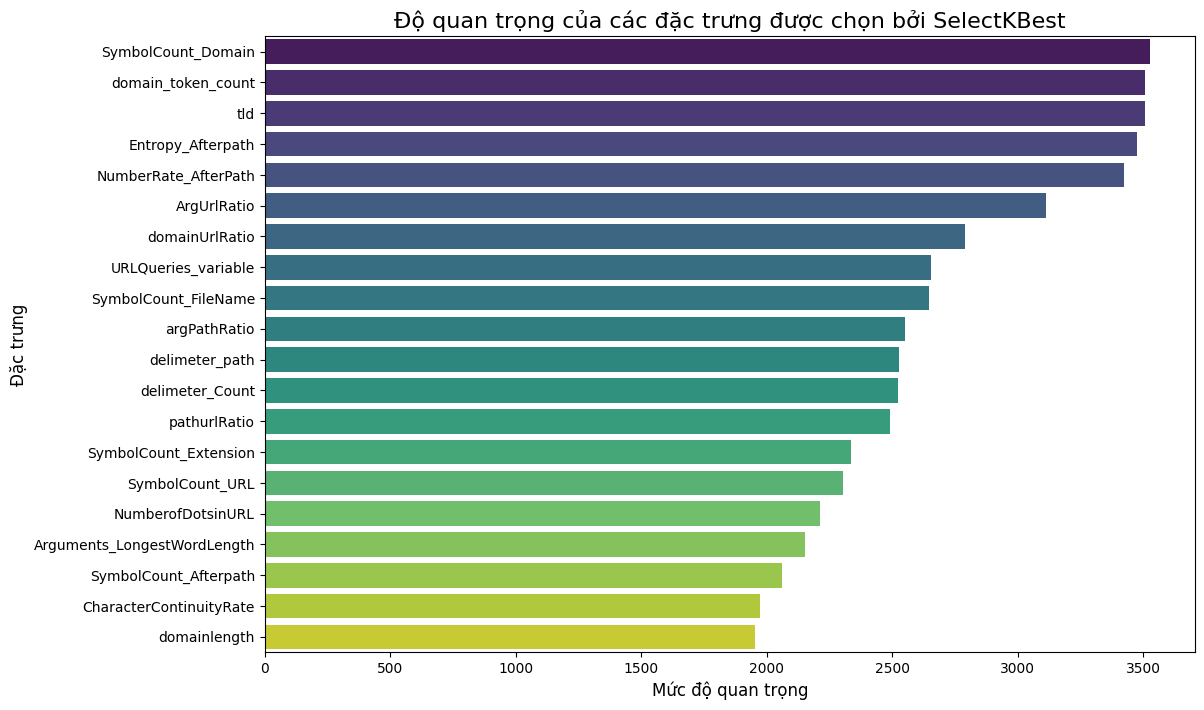

In [ ]:
# Lấy điểm số quan trọng của các đặc trưng đã chọn
feature_scores = selector.scores_[selector.get_support()]

# Tạo DataFrame chứa thông tin về các đặc trưng và điểm số
top_skbest_importance_df = pd.DataFrame({
    "Feature": top_skbest_features,
    "Importance": feature_scores
})

# Sắp xếp theo mức độ quan trọng
top_skbest_importance_df = top_skbest_importance_df.sort_values(by="Importance", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(data=top_skbest_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Độ quan trọng của các đặc trưng được chọn bởi SelectKBest", fontsize=16)
plt.xlabel("Mức độ quan trọng", fontsize=12)
plt.ylabel("Đặc trưng", fontsize=12)
plt.show()

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_skbest = pd.concat([data[top_skbest_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_skbest.to_csv("dataset_skbest.csv", index=False)

In [ ]:
# Lấy 60 đặc trưng còn lại

# Lấy danh sách 20 đặc trưng quan trọng nhất
skbest_20_features = set(top_skbest_features)

# Lấy danh sách 60 đặc trưng còn lại
skbest_60_features = list(all_features - skbest_20_features)

print(skbest_60_features)

['this.fileExtLen', 'spcharUrl', 'pathLength', 'Filename_LetterCount', 'Query_DigitCount', 'Extension_LetterCount', 'dld_getArg', 'executable', 'delimeter_Domain', 'LongestPathTokenLength', 'Path_LongestWordLength', 'ldl_domain', 'SymbolCount_Directoryname', 'Domain_LongestWordLength', 'ISIpAddressInDomainName', 'ldl_url', 'argDomanRatio', 'path_token_count', 'Entropy_DirectoryName', 'ArgLen', 'host_letter_count', 'ldl_path', 'ldl_getArg', 'NumberRate_DirectoryName', 'Querylength', 'Extension_DigitCount', 'avgpathtokenlen', 'LongestVariableValue', 'dld_path', 'Entropy_Extension', 'charcompace', 'URL_DigitCount', 'pathDomainRatio', 'NumberRate_FileName', 'dld_domain', 'dld_filename', 'host_DigitCount', 'urlLen', 'ldl_filename', 'dld_url', 'URL_Letter_Count', 'charcompvowels', 'avgdomaintokenlen', 'sub-Directory_LongestWordLength', 'isPortEighty', 'NumberRate_URL', 'NumberRate_Extension', 'Entropy_URL', 'File_name_DigitCount', 'Query_LetterCount', 'NumberRate_Domain', 'Entropy_Filename',

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
data_skbest_60 = pd.concat([data[skbest_60_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
data_skbest_60.to_csv("dataset_skbest_60.csv", index=False)

### Kết hợp kết quả từ 4 phương pháp
Sau khi thu thập danh sách các đặc trưng từ 4 phương pháp, bạn có thể kết hợp và chọn ra 20 đặc trưng xuất hiện nhiều nhất hoặc có tầm quan trọng cao nhất.

In [ ]:
# Tập hợp tất cả các đặc trưng được chọn
# Convert top_skbest_features to a list
top_skbest_features_list = top_skbest_features.tolist()

combined_features = list(set(top_rf_features + top_mi_features + top_rfe_features + top_skbest_features_list))

# Nếu số đặc trưng vượt quá 20, chọn dựa trên tần suất xuất hiện
from collections import Counter

feature_counts = Counter(top_rf_features + top_mi_features + top_rfe_features + top_skbest_features_list)
top_20_features = [feature for feature, _ in feature_counts.most_common(20)]

print("Top 20 đặc trưng quan trọng nhất:", top_20_features)

Top 20 đặc trưng quan trọng nhất: ['ArgUrlRatio', 'CharacterContinuityRate', 'pathurlRatio', 'NumberofDotsinURL', 'SymbolCount_Domain', 'avgdomaintokenlen', 'domain_token_count', 'domainlength', 'Entropy_Domain', 'argDomanRatio', 'NumberRate_URL', 'domainUrlRatio', 'argPathRatio', 'host_letter_count', 'urlLen', 'tld', 'Directory_LetterCount', 'Extension_LetterCount', 'NumberRate_Extension', 'avgpathtokenlen']


In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
final_data = pd.concat([data[top_20_features], y], axis=1)

In [ ]:
# Lưu dữ liệu đã chọn vào file CSV
final_data.to_csv("finaldataset_20.csv", index=False)

In [ ]:
# Lấy 60 đặc trưng còn lại

# Lấy danh sách 20 đặc trưng quan trọng nhất
final_20_features = set(top_20_features)

# Lấy danh sách 60 đặc trưng còn lại
final_60_features = list(all_features - final_20_features)

print(final_60_features)

['this.fileExtLen', 'spcharUrl', 'pathLength', 'Filename_LetterCount', 'Query_DigitCount', 'dld_getArg', 'delimeter_Domain', 'executable', 'Path_LongestWordLength', 'LongestPathTokenLength', 'SymbolCount_Afterpath', 'ldl_domain', 'SymbolCount_Directoryname', 'Domain_LongestWordLength', 'ISIpAddressInDomainName', 'ldl_url', 'path_token_count', 'Entropy_DirectoryName', 'ArgLen', 'ldl_path', 'ldl_getArg', 'delimeter_Count', 'NumberRate_DirectoryName', 'delimeter_path', 'Querylength', 'Extension_DigitCount', 'LongestVariableValue', 'SymbolCount_FileName', 'dld_path', 'Entropy_Extension', 'charcompace', 'URL_DigitCount', 'pathDomainRatio', 'NumberRate_FileName', 'dld_domain', 'dld_filename', 'host_DigitCount', 'Entropy_Afterpath', 'SymbolCount_URL', 'ldl_filename', 'dld_url', 'URL_Letter_Count', 'charcompvowels', 'sub-Directory_LongestWordLength', 'NumberRate_AfterPath', 'isPortEighty', 'URLQueries_variable', 'Entropy_URL', 'File_name_DigitCount', 'Query_LetterCount', 'NumberRate_Domain', '

In [ ]:
# Tạo DataFrame mới với các đặc trưng đã chọn
final_data_60 = pd.concat([data[final_60_features], y], axis=1)

# Lưu dữ liệu đã chọn vào file CSV
final_data_60.to_csv("finaldataset_60.csv", index=False)